# Train RBM on first 6 months pandemic sequences

In [1]:
import os, sys
# put this at the very top of your entry script or notebook, before importing numpy/torch
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

pgm_path = 'PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append(pgm_path + 'source/')
sys.path.append(pgm_path + 'utilities/')

# sys.path.append('DNA_utils/')

In [2]:
# imports

import rbm, RBM_utils

import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from global_variables import *
%matplotlib inline
path = 'seq_data/'
# filename = 'rbd_aligned_sequences_no_gap_ref.fasta'
filename = 'rbd_aligned_sequences.fasta'

e:\ESCAPE_MAP_DRAFT\PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
e:\ESCAPE_MAP_DRAFT\PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


In [3]:
import utilities, Proteins_utils, sequence_logo, plots_utils 
sequences = Proteins_utils.load_FASTA(path + filename) # Load protein sequences.
#shape
print('shape of sequences:', np.shape(sequences))
print('sequences:', sequences)



sequences=np.array(sequences)

shape of sequences: (2240, 178)
sequences: [[15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 ...
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]]


In [4]:
WT_SEQ.shape

(178,)

In [5]:

#first row is WT
train_sequences=np.vstack([WT_SEQ, sequences])
print('Train sequences shape:', sequences.shape)


Train sequences shape: (2240, 178)


## Add pandemic sequences

In [ ]:
import re
import numpy as np
import torch
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
FASTA = "seq_data/ns_mutated_spike.fasta"  

ALLVOCS_NUM_before = Proteins_utils.load_FASTA(FASTA, drop_duplicates=True)  # numeric encoding of seqeunces
print(ALLVOCS_NUM_before.shape)
import numpy as np

# Number of sequences
n = train_sequences.shape[0]#this is 100% addition of vocs. Change this to  20%, 40%; 60%, 80% for different percentages

# Random sample of indices
idx = np.random.choice(n, size=n, replace=False)

# Subset
VOCS_NUM_before = ALLVOCS_NUM_before[idx]
print(f"Total before 2020-07: {VOCS_NUM_before.shape}")
merged_seq = np.concatenate([VOCS_NUM_before, sequences], axis=0)
print(f"Merged shape: {merged_seq.shape}")


sequence_weights = np.ones(merged_seq.shape[0])
#first seq should have higher weight

RBM_P = rbm.RBM(
              visible = 'Potts', # Categorical visible data.
              hidden = 'dReLU', # double ReLU hidden units.
              n_v = merged_seq.shape[-1], # Data dimension (here, number of columns in MSA)
              n_cv = 21, # Number of categories (here, 20 amino acids + 1 gap)
              n_h = 100 # Number of hidden units: 100
              ) # RBM object initialization.

RBM_P.fit(merged_seq, weights = sequence_weights, n_iter=50, N_MC=10,verbose=1, vverbose=1, l1b=0.12) # Fit by Persistent Contrastive Divergence for 500 epochs, 10 Monte Carlo steps; L_1^2 sparse regularization penalty = 0.1.
RBM_utils.saveRBM('RBM_pandemic.data',RBM_P)#change name: pandemic + percentage 
print( RBM_P.likelihood(merged_seq).mean() ) # Evaluate partition function Z by Annealed Importance Sampling, then evaluate  sequences likelihood.



(3704, 178)
Total before 2020-07: (2241, 178)
Merged shape: (4481, 178)


In [22]:
import os
import re
import numpy as np
import torch
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter

# --- user/config ---
FASTA = "seq_data/ns_mutated_spike.fasta"   # numeric-encoded FASTA expected by Proteins_utils.load_FASTA
PCTS = [0.05, 0.10, 0.50, 1]

SEED  = 123
N_ITER = 50
N_HIDDEN = 100
L1B = 0.12
N_MC = 10

# --- helpers: safe access to optional 'sequences' array from caller env ---
def get_base_sequences_like(ref_array):
    """
    Use existing 'sequences' from the outer scope if defined.
    Else return an empty array with matching width and dtype.
    """
    try:
        base = sequences  # noqa: F821
        assert isinstance(base, np.ndarray)
        assert base.shape[1] == ref_array.shape[1]
        return base
    except Exception:
        return np.empty((0, ref_array.shape[1]), dtype=ref_array.dtype)

# --- load numeric sequences present "before" ---
ALLVOCS_NUM_before = Proteins_utils.load_FASTA(FASTA, drop_duplicates=True)
print("ALLVOCS_NUM_before shape:", ALLVOCS_NUM_before.shape)

# base set to merge with (if not provided by caller, this is empty)
BASE_SEQ = Proteins_utils.load_FASTA("seq_data/rbd_aligned_sequences.fasta")
print("Base set shape:", BASE_SEQ.shape)

# RNG
rng = np.random.default_rng(SEED)

# ensure output dir
os.makedirs("rbm_models", exist_ok=True)

for pct in PCTS:
    # sample pct of ALLVOCS_NUM_before without replacement
    n_total = BASE_SEQ.shape[0]
    n_keep = max(1, int(round(pct * n_total)))
    idx = rng.choice(n_total, size=n_keep, replace=False)
    VOCS_NUM_before = ALLVOCS_NUM_before[idx]
    print(f"[{int(pct*100)}%] sampled before-set shape:", VOCS_NUM_before.shape)

    # merge with base sequences
    merged_seq = np.concatenate([VOCS_NUM_before, BASE_SEQ], axis=0)
    print(f"[{int(pct*100)}%] merged shape:", merged_seq.shape)

    # weights: all ones 
    sequence_weights = np.ones(merged_seq.shape[0], dtype=np.float32)


    # build and fit RBM
    RBM_P = rbm.RBM(
        visible='Potts',
        hidden='dReLU',
        n_v=merged_seq.shape[-1],
        n_cv=21,
        n_h=N_HIDDEN
    )

    RBM_P.fit(
        merged_seq,
        weights=sequence_weights,
        n_iter=N_ITER,
        N_MC=N_MC,
        verbose=1,
        vverbose=1,
        l1b=L1B
    )

    # save with descriptive name
    save_name = f"rbm_models/RBM_pandemic_{int(pct*100)}.data"
    RBM_utils.saveRBM(save_name, RBM_P)
    # report mean likelihood
    try:
        ll = RBM_P.likelihood(merged_seq).mean()
        print(f"[{int(pct*100)}%] mean likelihood: {ll:.4f}")
    except Exception as e:
        print(f"[{int(pct*100)}%] likelihood eval skipped: {e}")


ALLVOCS_NUM_before shape: (3704, 178)
Base set shape: (2240, 178)
[5%] sampled before-set shape: (112, 178)
[5%] merged shape: (2352, 178)
Iteration number 0, pseudo-likelihood: -1.05
Starting epoch 1
[RBM] Iteration 1, time = 1.51s, pseudo-likelihood = -1.93
Starting epoch 2
[RBM] Iteration 2, time = 1.51s, pseudo-likelihood = -3.25
Starting epoch 3


e:\ESCAPE_MAP_DRAFT\PGM/source\layer.py:1188: RuntimeWarning: overflow encountered in divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)
e:\ESCAPE_MAP_DRAFT\PGM/source\layer.py:1225: RuntimeWarning: overflow encountered in divide
  p_plus = 1 / (1 + (etg_minus / np.sqrt(self._gamma_minus)


[RBM] Iteration 3, time = 1.48s, pseudo-likelihood = -4.23
Starting epoch 4
[RBM] Iteration 4, time = 1.33s, pseudo-likelihood = -6.21
Starting epoch 5
[RBM] Iteration 5, time = 1.39s, pseudo-likelihood = -6.06
Starting epoch 6
[RBM] Iteration 6, time = 1.40s, pseudo-likelihood = -6.09
Starting epoch 7
[RBM] Iteration 7, time = 1.34s, pseudo-likelihood = -6.52
Starting epoch 8
[RBM] Iteration 8, time = 1.37s, pseudo-likelihood = -5.36
Starting epoch 9
[RBM] Iteration 9, time = 1.37s, pseudo-likelihood = -3.28
Starting epoch 10
[RBM] Iteration 10, time = 1.40s, pseudo-likelihood = -3.72
Starting epoch 11
[RBM] Iteration 11, time = 1.34s, pseudo-likelihood = -4.30
Starting epoch 12
[RBM] Iteration 12, time = 1.41s, pseudo-likelihood = -2.78
Starting epoch 13
[RBM] Iteration 13, time = 1.35s, pseudo-likelihood = -1.84
Starting epoch 14
[RBM] Iteration 14, time = 1.38s, pseudo-likelihood = -0.60
Starting epoch 15
[RBM] Iteration 15, time = 1.40s, pseudo-likelihood = -0.41
Starting epoch 16

# Application to df bloom

# protein Expression

In [17]:
df_bloom=pd.read_csv('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.csv')
df_bloom=df_bloom[df_bloom['site_SARS2']>=349] 
df_bloom=df_bloom[df_bloom['site_SARS2']<=526]
#reset index
df_bloom=df_bloom.reset_index(drop=True)
#sequence column to fasta file
with open('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta', 'w') as f:
    for index, row in df_bloom.iterrows():
        #if * in sequence, remove sequence
        if '*' in row['sequence']:
            continue
        f.write('>' + str(index) + '\n')
        f.write(row['sequence'] + '\n')
# df_bloom

In [18]:
bloom_sequences=Proteins_utils.load_FASTA('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta')
print('shape of sequences:', np.shape(bloom_sequences))
bloom_sequences = [seq[BEGIN:-END] for seq in bloom_sequences]
bloom_sequences=np.array(bloom_sequences)
# bloom_sequences=one_hot_encode_matrix(bloom_sequences)
bloom_sequences.shape

shape of sequences: (3327, 201)


(3327, 178)

Mismatch dimensions (100, 100), [10, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [10, 178, 21], reinitializating I


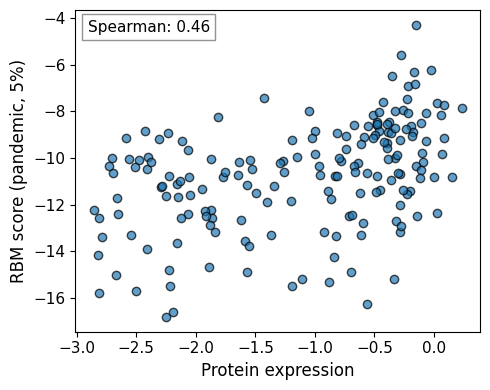

Mismatch dimensions (100, 100), [10, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [10, 178, 21], reinitializating I


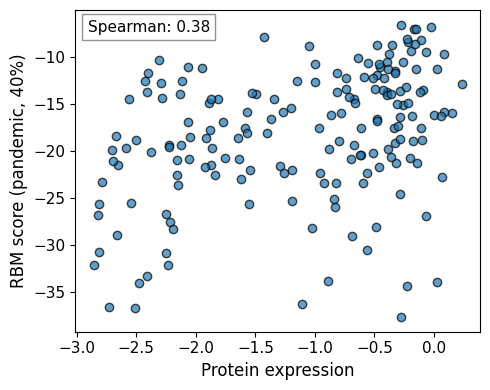

Mismatch dimensions (100, 100), [10, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [10, 178, 21], reinitializating I


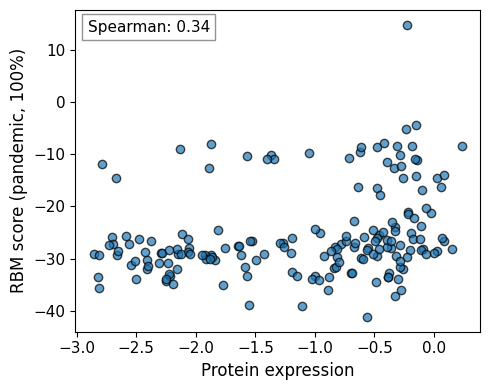

In [29]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score
import numpy as np

# percentages that you trained/saved earlier
PCTS = [5, 40, 100]

# preload WT and Bloom sequences once
WT_embe = Proteins_utils.load_FASTA('seq_data/rbd_wt.fasta')
WT_embe = np.array([seq[BEGIN:-END] for seq in WT_embe])

# compute per-PCT figure
for pct in PCTS:
    rbm_path = f"rbm_models/RBM_pandemic_{pct}.data"
    RBM_P = RBM_utils.loadRBM(rbm_path)

    # likelihoods
    df_bloom = df_bloom.copy()
    sequences_likelihood = RBM_P.likelihood(bloom_sequences)
    df_bloom["likelihood"] = np.where(np.isnan(sequences_likelihood), -300.0, sequences_likelihood)

    likelihood_WT = float(RBM_P.likelihood(WT_embe)[0])

    # delta E and site-level average
    df_bloom["deltaE"] = -likelihood_WT + df_bloom["likelihood"]
    df_bloom_avg = (df_bloom
                    .groupby("site_SARS2", as_index=False)
                    .agg(expr_avg=("expr_avg", "mean"),
                         deltaE=("deltaE", "mean")))

    # stats
    spearman_corr, spearman_pval = stats.spearmanr(df_bloom_avg["expr_avg"], df_bloom_avg["deltaE"])
    r2 = r2_score(df_bloom_avg["expr_avg"], df_bloom_avg["deltaE"])

    # plot
    plt.figure(figsize=(5, 4))
    plt.scatter(df_bloom_avg["expr_avg"], df_bloom_avg["deltaE"],
                alpha=0.7, edgecolor="black")

    plt.xlabel("Protein expression", fontsize=12)
    plt.ylabel(f"RBM score (pandemic, {pct}%)", fontsize=12)

    textstr = f"Spearman: {spearman_corr:.2f}"
    plt.text(0.03, 0.97, textstr, transform=plt.gca().transAxes,
             fontsize=11, va="top", bbox=dict(facecolor="white", alpha=0.85, edgecolor="grey"))

    ax = plt.gca()
    ax.tick_params(labelsize=11)
    # ax.spines["top"].set_visible(False)
    # ax.spines["right"].set_visible(False)

    plt.tight_layout()
    plt.show()


# Obsolete

likelihood_WT: [-15917.381]


In [ ]:
df_bloom

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence,likelihood,deltaE
0,19,349,S,A,S349A,S19A,-0.35,-0.32,-0.34,-1.37,-0.89,-1.13,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...,-15924.975586,-7.594727
1,19,349,S,C,S349C,S19C,0.00,-0.24,-0.12,-3.09,-0.97,-2.03,NITNLCPFGEVFNATRFACVYAWNRKRISNCVADYSVLYNSASFST...,-15935.108398,-17.727539
2,19,349,S,D,S349D,S19D,-0.48,-0.52,-0.50,-1.06,-1.21,-1.14,NITNLCPFGEVFNATRFADVYAWNRKRISNCVADYSVLYNSASFST...,-15925.693359,-8.312500
3,19,349,S,E,S349E,S19E,-1.08,-1.23,-1.15,-2.22,-2.04,-2.13,NITNLCPFGEVFNATRFAEVYAWNRKRISNCVADYSVLYNSASFST...,-15922.683594,-5.302734
4,19,349,S,F,S349F,S19F,-1.96,-2.11,-2.03,-2.67,-2.33,-2.50,NITNLCPFGEVFNATRFAFVYAWNRKRISNCVADYSVLYNSASFST...,-15935.109375,-17.728516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,196,526,G,R,G526R,G196R,-0.08,-0.08,-0.08,-0.19,-0.40,-0.30,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-15952.529297,-35.148438
3323,196,526,G,S,G526S,G196S,0.00,-0.05,-0.02,-0.14,-0.13,-0.14,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-15944.903320,-27.522461
3324,196,526,G,T,G526T,G196T,0.05,-0.04,0.01,-0.20,-0.11,-0.15,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-15950.830078,-33.449219
3325,196,526,G,V,G526V,G196V,-0.07,-0.02,-0.04,-0.12,-0.13,-0.12,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-15951.089844,-33.708984


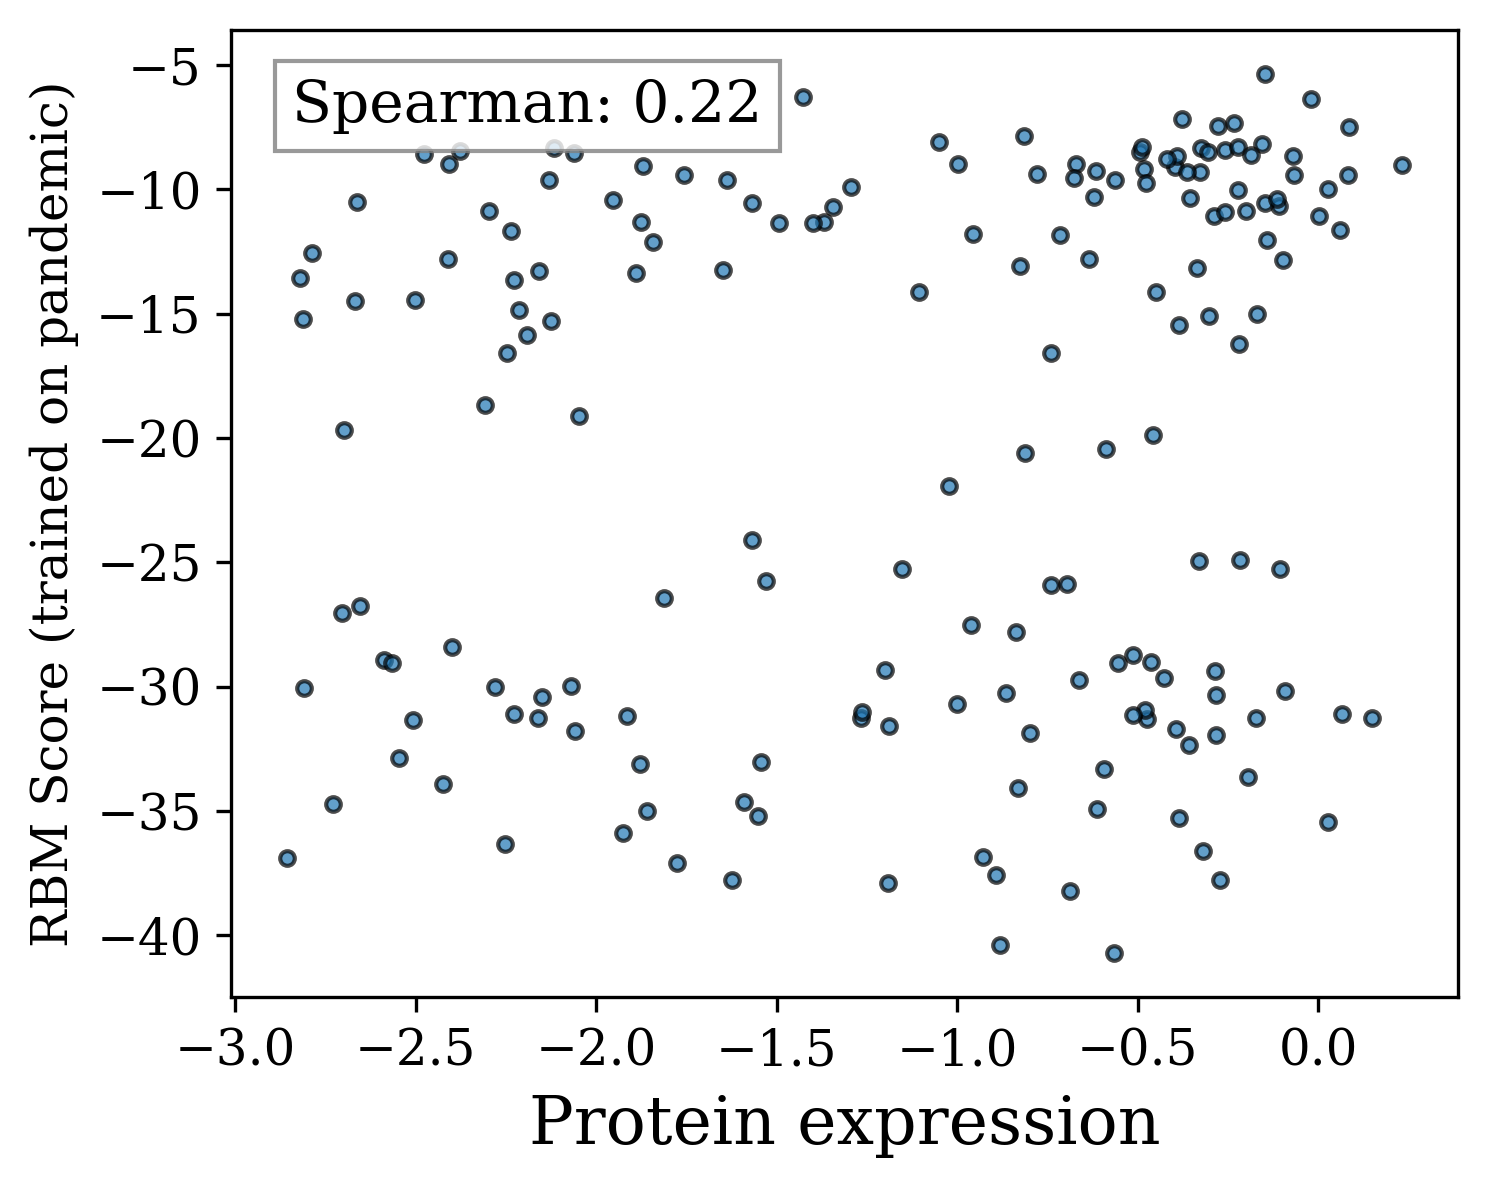

(0.22026888215436524, 0.003132543337209201, -595.8989935630163)

In [71]:
import scipy.stats as stats
from sklearn.metrics import r2_score

# Calculate Spearman correlation
spearman_corr, spearman_pval = stats.spearmanr(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'])

# Calculate R² score
r2 = r2_score(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'])

# Create figure
plt.figure(figsize=(5, 4))  # Slightly larger for readability

# Scatter plot with enhanced visualization
plt.scatter(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'], color='#1f77b4', alpha=0.7, edgecolor='black')

# Labels and title
plt.xlabel('Protein expression', fontsize=16)
plt.ylabel('RBM Score (trained on pandemic)', fontsize=12)
# plt.title(r'$\Delta E_{RBM}$ vs Expression Average', fontsize=16)

# Adding Spearman correlation in a small box inside the plot
textstr = f"Spearman: {spearman_corr:.2f}"
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey'))

# Grid and ticks
# plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Removing top and right spines for a cleaner look
ax = plt.gca()



# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Print correlation and R² score
spearman_corr, spearman_pval, r2


# Obsolete

# Train pandemic EscapeMap

In [ ]:
from escape_map import *
from escape_map_torch import *

def fit_escape_map_sigmoid_diff(
    seqs,
    y,
    rbm,
    kd_vectors,
    ace2_vector,
    epochs=50,
    batch_size=512,
    lr=2e-1,
    weight_decay=1e-5,
    device=None,
    dtype=torch.float64,
):
    device = device or (
        torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    )
    X = torch.as_tensor(seqs, dtype=torch.long, device=device)
    Y = torch.as_tensor(y.astype(float), dtype=dtype, device=device)

    model = EscapeMapTorch(
        rbm=rbm,
        kd_vectors=kd_vectors,
        ace2_vector=ace2_vector,
        total_beta=1.0,
        device=device,
        dtype=dtype,
    ).to(device)

    # Optimizer: now include raw_concentrations
    params = [
        model.raw_concentrations,
        model.raw_beta,
        model.raw_ace2,
        model.raw_total_beta,
    ]
    opt = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

    # Class imbalance handling
    pos = float(Y.sum().item())
    neg = float(Y.numel() - pos)
    pos_weight = torch.tensor(neg / max(pos, 1.0), dtype=dtype, device=device)
    bce = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    N = X.size(0)
    idx_all = torch.arange(N, device=device)
    WT = torch.as_tensor(WT_SEQ, dtype=torch.long, device=device)

    for _ in range(epochs):
        perm = idx_all[torch.randperm(N, device=device)]
        for bi in range(ceil(N / batch_size)):
            bidx = perm[bi * batch_size : (bi + 1) * batch_size]
            xb, yb = X[bidx], Y[bidx]

            opt.zero_grad()
            wt_score = -model(WT)  # scalar
            scores_b = -model(xb)  # [B]
            logits = scores_b - wt_score  # classification margin vs WT
            loss = bce(logits, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(params, max_norm=10.0)
            opt.step()
            print("model.raw_beta:", model.raw_beta.item())
            print("model.raw_ace2:", model.raw_ace2.item())

    # Final evaluation
    with torch.no_grad():
        wt_score = -model(WT)
        scores = -model(X)
        logits_full = scores - wt_score
        prob = torch.sigmoid(logits_full).cpu().numpy()
        auc = roc_auc_score(y, prob)
        rc = model.raw_concentrations.detach().cpu().numpy()
        rb = float(model.raw_beta.detach().cpu())
        ra = float(model.raw_ace2.detach().cpu())
        tb = float(
            torch.exp(model.raw_total_beta).detach().cpu()
        )  # total_beta in linear scale

    return {
        "model": model,
        "prob": prob,
        "AUC": auc,
        "raw_concentrations": rc,
        "raw_beta": rb,
        "raw_ace2": ra,
        "total_beta": tb,
    }


In [63]:

df_base = pd.read_csv("fitness/rbd_dist_one_scores_gisaid.csv")
df_base=df_base[df_base['i']>=349] 
df_base=df_base[df_base['i']<=526]
df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")
seqs=Proteins_utils.load_FASTA('fitness/single_variants.fasta', drop_duplicates=False)
import pandas as pd

# Example cutoff
cutoff = pd.to_datetime("2020-07-01")

# Binary training labels
Y_train = np.array(((~df_base['first_seen_100'].isna()) & 
           (df_base['first_seen_100'] < cutoff)).astype(int))

print('mutations present in train:',Y_train.shape)


out = fit_escape_map_sigmoid_diff(
    seqs=seqs, y=Y_train, rbm=RBM_P, kd_vectors=KD_VECTORS, ace2_vector=ACE2_KD_VECTOR,
    epochs=30, batch_size=1024, lr=2e-1, weight_decay=1e-5,
)
print(out["AUC"], out["raw_ace2"], out["raw_beta"], out["total_beta"], out["raw_concentrations"])


mutations present in train: (1401,)
model.raw_beta: -2.1999999894303808
model.raw_ace2: -10.199999356295791
model.raw_beta: -2.2188550476386886
model.raw_ace2: -10.398821466396926
model.raw_beta: -2.212717038322259
model.raw_ace2: -10.598538616695967
model.raw_beta: -2.2094099705468593
model.raw_ace2: -10.797395502553547
model.raw_beta: -2.221839831117754
model.raw_ace2: -10.997388300430988
model.raw_beta: -2.1740013596753367
model.raw_ace2: -11.197377767424788
model.raw_beta: -2.1218096429143856
model.raw_ace2: -11.396080053828022
model.raw_beta: -2.1388916221493353
model.raw_ace2: -11.594400704908319
model.raw_beta: -2.155844246640709
model.raw_ace2: -11.791357646563018
model.raw_beta: -2.2111490546725063
model.raw_ace2: -11.982438475219768
model.raw_beta: -2.267940508498816
model.raw_ace2: -12.171934359245139
model.raw_beta: -2.3135500722700915
model.raw_ace2: -12.362000542408225
model.raw_beta: -2.34619469060317
model.raw_ace2: -12.551890013476543
model.raw_beta: -2.380493645410488

In [65]:
param_row = {
    "raw_beta": float(out["raw_beta"]),
    "raw_ace2": float(out["raw_ace2"]),
    "total_beta": float(out["total_beta"]),
}
ab_names=list(KD_VECTORS.keys())
for name, val in zip(ab_names, out["raw_concentrations"]):
    param_row[f"raw_c_{name}"] = float(val)

params_df = pd.DataFrame([param_row])
params_path = "param_pandemic_model.csv"
params_df.to_csv(params_path, index=False)

Test set size = 1401


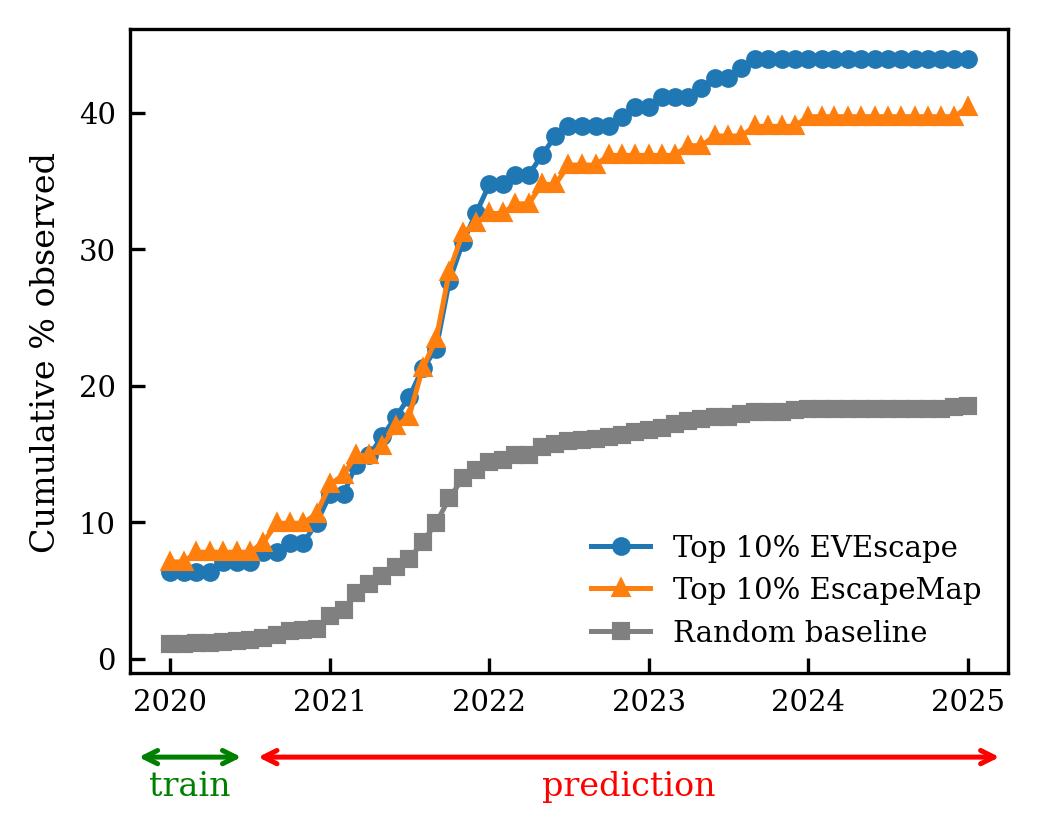

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates



th = 90  # percentile threshold

# ---------- Prepare frames (single pass, no seeds) ----------
df = df_base.copy()

# load EscapeMap scores
df["escapemap"] = out["prob"]

print(f"Test set size = {len(df)}")

# thresholds
thr_eve = np.nanpercentile(df["evescape"], th)
thr_em  = np.nanpercentile(df["escapemap"], th)

# subsets (top 100-th % for each scoring scheme)
top_eve = df[df["evescape"]   >= thr_eve].copy()
top_em  = df[df["escapemap"]  >= thr_em].copy()

# drop NaT
with_seen_eve = top_eve.dropna(subset=["first_seen_100"]).copy()
with_seen_em  = top_em.dropna(subset=["first_seen_100"]).copy()

# ---------- Global month axis ----------
mins, maxs = [], []
for x in (with_seen_eve, with_seen_em):
    if not x.empty:
        mins.append(x["first_seen_100"].min())
        maxs.append(x["first_seen_100"].max())

if not mins or not maxs:
    raise RuntimeError("No valid dates found after filtering; check inputs.")

global_start = min(mins)
global_end   = max(maxs)
global_months = pd.date_range(global_start, global_end, freq="MS")

def cum_frac(seen_df, denom, months):
    if denom == 0 or seen_df.empty:
        return np.zeros(len(months), dtype=float)
    dates = np.sort(seen_df["first_seen_100"].to_numpy("datetime64[ns]"))
    months64 = months.to_numpy("datetime64[ns]")
    counts = np.searchsorted(dates, months64, side="right")
    return (counts / denom) * 100.0

# ---------- Curves on common axis ----------
tot_eve, tot_em = len(top_eve), len(top_em)
avg_eve = cum_frac(with_seen_eve, tot_eve, global_months)
avg_em  = cum_frac(with_seen_em,  tot_em,  global_months)

# random: percentage of total mutations that appeared in pandemic
seen_all = df_base.dropna(subset=["first_seen_100"]).copy()
avg_rnd = cum_frac(seen_all, len(df_base), global_months)

# --- Plot (single curves, no seed averaging) ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))

ax.plot(global_months, avg_eve, marker="o", label=f"Top {100-th}% EVEscape")
ax.plot(global_months, avg_em,  marker="^", label=f"Top {100-th}% EscapeMap")
ax.plot(global_months, avg_rnd, marker="s", label="Random baseline", color="gray")

# X axis: yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis="x", labelrotation=0)

ax.set_ylabel("Cumulative % observed")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")
fig.tight_layout(pad=0.5)

# --- Train/prediction arrows placed lower ---
x0_num, x1_num = ax.get_xlim()
x0 = mdates.num2date(x0_num)
x1 = mdates.num2date(x1_num)
mid = cutoff

y = -0.13
xf = ax.get_xaxis_transform()  # data x, axes-fraction y

ax.annotate("", xy=(mid, y), xytext=(x0, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="green"), annotation_clip=False)
cx_train = mdates.num2date((mdates.date2num(x0) + mdates.date2num(mid)) / 2)
ax.text(cx_train, y - 0.02, "train", color="green", ha="center", va="top",
        transform=xf, clip_on=False)

ax.annotate("", xy=(x1, y), xytext=(mid, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="red"), annotation_clip=False)
cx_pred = mdates.num2date((mdates.date2num(mid) + mdates.date2num(x1)) / 2)
ax.text(cx_pred, y - 0.02, "prediction", color="red", ha="center", va="top",
        transform=xf, clip_on=False)

plt.show()


# Generate sequences

In [66]:
# --- Reproducibility (optional) ---
np.random.seed(42)
model=load_escape_map_from_csv("param_pandemic_model.csv")
# --- Load model and set base concentrations ---
model.raw_concentrations = -12.0 * np.ones(len(KD_VECTORS), dtype=np.float64)

# total_beta = (1 / exp(raw_beta)) * coeff_beta
base_beta_factor = 1.0 / np.exp(model.raw_beta)

# --- Beta sweep & sampling config ---
coeff_beta=3
N_SEQUENCES_PER_BETA = 500
N_CHAINS = 5
WARMING_STEPS = 1000
STEPS_BETWEEN = 100

# --- Outputs we’ll accumulate across betas ---
fasta_lines = []
score_rows = []
seq_counter = 0

# set current beta (no copying needed; just update the scalar)
model.total_beta = base_beta_factor * float(coeff_beta)

# --- Generate sequences ---
seqs = gen_artif_data(
    model,
    n_sequences=N_SEQUENCES_PER_BETA,
    n_chains=N_CHAINS,
    warming_steps=WARMING_STEPS,
    steps_between_sampling=STEPS_BETWEEN,
    # init_seq=INIT_SEQ,  # optional
)

# --- Score sequences (normalize like your original script) ---
scores = score_seq_batch(model, seqs) / model.total_beta  # (N,)

# --- Convert to amino-acid strings and append to global FASTA ---
seqs_str = Proteins_utils.num2seq(seqs)
for seq_str, sc in zip(seqs_str, scores):
    seq_id = f"seq{seq_counter}"
    fasta_lines.append(f">{seq_id} | beta={coeff_beta:.3f}\n{seq_str}\n")
    score_rows.append({
        "seq_id": seq_id,
        "score": float(sc),
        "coeff_beta": float(coeff_beta),
    })
    seq_counter += 1

# --- Save a single FASTA with all sequences across betas ---
with open("pandemic_generated_sequences_beta.fasta", "w") as fasta_file:
    fasta_file.writelines(fasta_lines)
print("All sequences saved to 'pandemic_generated_sequences_beta.fasta'")




Generating sequences...


100%|██████████| 5/5 [03:26<00:00, 41.39s/it]


output shape: (500, 178)
All sequences saved to 'pandemic_generated_sequences_beta.fasta'
